# Household Power Comsumption Analysis

The data used for this analysis is from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

It contains the power consumption of one household located in France with a one-minute sampling rate over almost 4 years.

This notebook is a walkthrough on how to implement a cluster analysis using timeseries data.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns    
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans 
from tslearn.preprocessing import TimeSeriesScalerMinMax
%matplotlib inline
plt.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets

In [15]:
# load data

filepath = './power_consumption_hourly.csv'

power_consumption_hourly = pd.read_csv(filepath,  header=0, low_memory=False, infer_datetime_format=True, parse_dates=['datetime'], index_col='datetime')
power_consumption_hourly.head()

Global_active_power  year  quarter  month  day  hour  \
datetime                                                                    
2006-12-16 17:00:00              152.024  2006        4     12   16    17   
2006-12-16 18:00:00              217.932  2006        4     12   16    18   
2006-12-16 19:00:00              204.014  2006        4     12   16    19   
2006-12-16 20:00:00              196.114  2006        4     12   16    20   
2006-12-16 21:00:00              183.388  2006        4     12   16    21   

                     weekday  is_weekend weekday_weekend  
datetime                                                  
2006-12-16 17:00:00        5         NaN             NaN  
2006-12-16 18:00:00        5         0.0         Weekday  
2006-12-16 19:00:00        5         0.0         Weekday  
2006-12-16 20:00:00        5         0.0         Weekday  
2006-12-16 21:00:00        5         0.0         Weekday

In [16]:
# get only Global active power column and reshape data

cluster_data = power_consumption_hourly[['Global_active_power']]
cluster_data['hour'] = cluster_data.index.hour
cluster_data.index = cluster_data.index.date

power_consumption_pivot = cluster_data.pivot(columns='hour')
power_consumption_pivot = power_consumption_pivot.dropna()

power_consumption_pivot.columns = power_consumption_pivot.columns.get_level_values(1)

# scale data to ensure that we don't end up giving more weight to some features than others
X = power_consumption_pivot.values.copy()
sc = MinMaxScaler()
X = sc.fit_transform(X)

## Dynamic Time Warping as distance metric

There are different types of time series clusterings - hierarchical, feature-based, and pattern-based.

For this analysis, we will use pattern-based clustering using tslearn's TimeSeriesKMeans which enables us to use DTW as distance metric.

Dynamic Time Warping (DTW) is a technique to measure similarity between two temporal sequences that do not align exactly in time, speed, or length. It has the advantage over Euclidean distance since it is considers time shifts and accounts for the time dimension of the data.

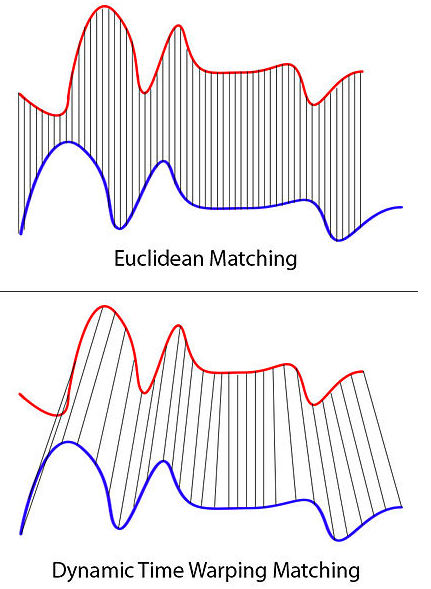

source: Wiki Commons https://commons.wikimedia.org/wiki/File:Euclidean_vs_DTW.jpg

Note that while the two time series have an overall similar shape, they are not aligned in the time axis. Euclidean distance, which assumes the ith point in one sequence is aligned with the ith point in the other, will produce a pessimistic dissimilarity measure. The non-linear Dynamic Time Warped alignment allows a more intuitive distance measure to be calculated.

1. Divide the two series into equal points.
2. Calculate the euclidean distance between the first point in the first series and every point in the second series. Store the minimum distance calculated. (this is the ‘time warp’ stage)
3. Move to the second point and repeat 2. Move step by step along points and repeat 2 till all points are exhausted.
4. Repeat 2 and 3 but with the second series as a reference point.
5. Add up all the minimum distances that were stored and this is a true measure of similarity between the two series.

In [17]:
df = power_consumption_pivot.T

fig = px.line(df, color_discrete_sequence=['rgba(0, 48, 73, 0.03)'])
fig.layout.update(showlegend=False) 
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    ),
    xaxis_title='hour',
    yaxis_title='kilowatts',
    title='Daily Power Consumption'
)
fig.show()

## Find the silhouette scores to get the number of clusters

Silhouette scores measures how similar a point is to its assigned cluster and how dissimilar it is to other points in other clusters.

Steps to find the silhouette coefficient of an i’th point:

Compute a(i): The average distance of that point with all other points in the same clusters.

Compute b(i): The average distance of that point with all the points in the closest cluster to its cluster.

Compute s(i) — silhouette coefficient or i’th point using below mentioned formula.

After computing the silhouette coefficient for each point, average it out to get the silhouette score.

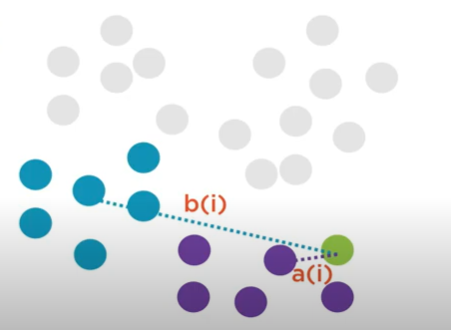

source: https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

In [5]:
sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

for n_cluster in n_cluster_list:
    
    kmeans = TimeSeriesKMeans(n_clusters=n_cluster, metric='dtw',random_state=32)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

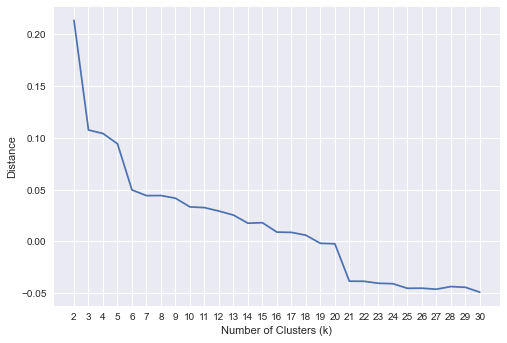

In [6]:
plt.plot(n_cluster_list, sillhoute_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.xticks(n_cluster_list)
plt.show()

## K-means clustering

Now that we have identified our distance metric and computed for the silhouette scores to get the optimal number of clusters, we can proceed with clustering our data using K-means.

Rule of thumb is to pick k (number of clusters) where the point is at its peak. In the case of the plot above, it's 2. However, 2 clusters do not really give us much information so we can settle for 3, the next highest point.

To better appreciate and understand the clusters, it's best to create a visualization of it.

In [18]:
kmeans = TimeSeriesKMeans(n_clusters=3, metric='dtw',random_state=32)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
power_consumption_pivot = power_consumption_pivot.set_index(cluster_found_sr, append=True)

In [19]:
# create a dataframe to inspect the clusters later
power_consumption_pivot_new = power_consumption_pivot.reset_index(level='cluster', col_level=0)
power_consumption_pivot_new = power_consumption_pivot_new.replace({'cluster': {0: 1, 1: 2, 2: 3}})
power_consumption_pivot_new.columns.name = None

In [26]:
cluster_0 = power_consumption_pivot[power_consumption_pivot.index.isin([0], level=1)]
cluster_0 = cluster_0.droplevel('cluster')
cluster_0.columns.name = None

cluster_1 = power_consumption_pivot[power_consumption_pivot.index.isin([1], level=1)]
cluster_1 = cluster_1.droplevel('cluster')
cluster_1.columns.name = None

cluster_2 = power_consumption_pivot[power_consumption_pivot.index.isin([2], level=1)]
cluster_2 = cluster_2.droplevel('cluster')
cluster_2.columns.name = None

In [29]:
fig1 = px.line(cluster_0.T,color_discrete_sequence=['rgba(0, 48, 73, 0.02)'])
fig2 = px.line(cluster_0.median().T,color_discrete_sequence=['rgba(0, 48, 73, 0.9)'])

fig3 = px.line(cluster_1.T,color_discrete_sequence=['rgba(214, 40, 40, 0.02)'])
fig4 = px.line(cluster_1.median().T,color_discrete_sequence=['rgba(214, 40, 40, 0.9)'])

fig5 = px.line(cluster_2.T,color_discrete_sequence=['rgba(252, 191, 73, 0.02)'])
fig6 = px.line(cluster_2.median().T,color_discrete_sequence=['rgba(252, 191, 73, 0.9)'])

fig7 = go.Figure(data=fig1.data + fig2.data + fig3.data + fig4.data + fig5.data + fig6.data)
fig7.layout.update(showlegend=False) 
fig7.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    ),
    xaxis_title='hour',
    yaxis_title='kilowatts',
    title='Daily Power Consumption Clusters using K-Means and Dynamic Time Warping (DTW)'
)
fig7.show()

The shapes of the lines are somewhat similar to what we have in our EDA (https://github.com/knpoblete/general-projects/blob/main/notebooks/household-power-consumption.ipynb)

## Inspect clusters to see what's common in each clusters

In [30]:
power_consumption_pivot_new.index = pd.to_datetime(power_consumption_pivot_new.index)
power_consumption_pivot_new['day_of_week'] = power_consumption_pivot_new.index.day_name()
power_consumption_pivot_new['day']=power_consumption_pivot_new.index.weekday
power_consumption_pivot_new['is_weekend'] = (power_consumption_pivot_new['day'] >= 5).astype(int)
dic={1:'Weekend',0:'Weekday'}
power_consumption_pivot_new['weekday_weekend'] = power_consumption_pivot_new.is_weekend.map(dic)
power_consumption_pivot_new['cluster'] = power_consumption_pivot_new['cluster'].astype('category')

In [31]:
season = {'month':[1,2,3,4,5,6,7,8,9,10,11,12],
        'season':['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']}
season = pd.DataFrame(season)

power_consumption_pivot_new['month']=power_consumption_pivot_new.index.month
power_consumption_pivot_new = pd.merge(power_consumption_pivot_new,season, on='month')

power_consumption_pivot_new['season_weekday'] = power_consumption_pivot_new['season'] + power_consumption_pivot_new['weekday_weekend'].astype(str)

In [32]:
fig=px.histogram(power_consumption_pivot_new, 
                   x='cluster',
                   color='cluster',
                   color_discrete_map={
                     1: '#003049',
                     2: '#D62828',
                     3: '#FCBF49'},
                   text_auto=True)
fig.update_xaxes(type='category')
fig.show()

- Cluster 2 accounts for most of the time series followed by cluster 3 then cluster 1

### Create a dropdown menu to select columns

In [33]:
def hist(select='weekday_weekend'):
    fig=px.histogram(power_consumption_pivot_new, 
                   x=select, 
                   color='cluster',
                   color_discrete_map={
                     1: '#003049',
                     2: '#D62828',
                     3: '#FCBF49'},
                   text_auto=True,
                   barmode='group')
    fig.show()

In [36]:
widgets.interact(hist, select=['weekday_weekend','day_of_week','season','season_weekday'])

interactive(children=(Dropdown(description='select', options=('weekday_weekend', 'day_of_week', 'season', 'sea…

<function __main__.hist(select='weekday_weekend')>

#### Weekday v weekend
- Weekdays are predominantly cluster 2
- Weekends almost around the same spread of clusters with cluster 2 leading by some

#### Day of the week
- All days except Sundays are predominantly from cluster 2
- Sundays have high number of cluster 1 but is followed closely by the other 2 clusters

#### Seasons
- All seasons except for summer are predominantly from cluster 2
- Cluster 3 accounts for most of the summer
- Winter has more cluster 1 time series compared to other seasons

#### Interaction between weekday/weekend and season
- Winter usage for cluster 1 in both weekdays and weekends are around the same
- Evident that summer usage dominates cluster 3

### Flip the axis to investigate further

In [37]:
def hist(select='weekday_weekend'):
    fig=px.histogram(power_consumption_pivot_new, 
                   x='cluster', 
                   color=select,
                   color_discrete_map={
                     1: '#003049',
                     2: '#D62828',
                     3: '#FCBF49'},
                   text_auto=True,
                   barmode='group',
                   color_discrete_sequence=px.colors.qualitative.Bold)
    fig.show()

In [38]:
widgets.interact(hist, select=['weekday_weekend','day_of_week','season','season_weekday'])

interactive(children=(Dropdown(description='select', options=('weekday_weekend', 'day_of_week', 'season', 'sea…

<function __main__.hist(select='weekday_weekend')>

#### Weekday v weekend
- Cluster 1 has fewer weekends compared to clusters 2 and 3

#### Day of the week
- Wednesdays have the highest frequency in cluster 1
- Mondays and Saturdays have the highest frequencies in cluster 2
- Sundays and Thursdays have the highest frequencies in cluster 3

#### Seasons
- Cluster 1 has more winter time series compared to other clusters and low number of summer time series
- Cluster 2 has more fall time series and also low number of summer time series
- Cluster 3 has more summer time series and low winter time series

#### Interaction between weekday/weekend and season
- Cluster 1 is mostly winter usage
- Cluster 2 is mostly weekday usage in fall, spring, winter
- Cluster 3 is mostly weekday summer usage

To sum it all up -

Cluster 1 is mostly winter usage. There's also an indication of high usage on Wednesdays. EDA has shown that there's an increase in laundry submeter during these days especially on Wednesdays.

Cluster 2 is where majority of the time series are classified. It accounts for fall and spring usage. There's also an indication of weekday usage based on its shape and from how cluster 2 is composed.

Cluster 3 is mostly summer usage. Power usage is low during this season.

# References

[1] Medium. Dynamic Time Warping with Time Series. Retrieved from:
https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950

[2] Towards Data Science. Silhouette Method Better than Elbow Method to Find Optimal Clusters. Retrieved from:
https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891